In [274]:
import numpy as np
from openqaoa.problems import BinPacking, MaximumCut, TSP, ShortestPath
from openqaoa.utilities import plot_graph
import json
import pprint
import networkx as nx

In [275]:
desiredProblemType = 'ShortestPath' #options: 'BinPacking', 'MaxCut', 'TSP', 'ShortestPath'

In [276]:
if desiredProblemType == 'TSP': #doesnt seem possible to get a non-trivial example of this problem in less than 12 qubits
    n_items = 2 # number of items
    n_bins = 2 # maximum number of bins the solution will be explored on
    min_weight = 1 # minimum weight of the items
    max_weight = 3 # maximum weight of the items
    weight_capacity = 5 # weight capacity of the bins
    weights = np.random.default_rng(seed=1234).integers(low=min_weight, high=max_weight, size=n_items) # random instance of the problem

    bpp = BinPacking(weights, weight_capacity, n_bins=n_bins, simplifications=False) #it is here that you would specifiy the penalty for the bin packing problem
    quboProb = bpp.qubo

elif desiredProblemType == 'MaxCut':
    G = nx.generators.fast_gnp_random_graph(n=10, p=0.6) #you can fix the seed for the graphs here
    maxcut_prob = MaximumCut(G)
    quboProb = maxcut_prob.qubo

elif desiredProblemType == 'TSP':
    G = nx.generators.fast_gnp_random_graph(n=4, p=0.6)
    nx.set_edge_attributes(G, values = 1, name = 'weight')
    tsp_prob = TSP(G=G, A=10, B=1)
    quboProb = tsp_prob.qubo   

elif desiredProblemType == 'ShortestPath': #not sure that the exact solver is working right for this one
    G = nx.generators.fast_gnp_random_graph(n=6, p=0.6)
    nx.set_edge_attributes(G, values = 1, name = 'weight')
    nx.set_node_attributes(G, values = 1, name = 'weight')
    sp_prob = ShortestPath(G, source=0, dest=5)
    quboProb = sp_prob.qubo

quboProb.hamiltonian.expression

-0.5Z_{10} - 0.5Z_{1} - 0.5Z_{2} - 1.0Z_{0}Z_{4} - 1.0Z_{0}Z_{7} - 1.0Z_{0}Z_{8} - 1.0Z_{1}Z_{10} - 1.0Z_{1}Z_{9} - 1.0Z_{2}Z_{11} - 1.0Z_{2}Z_{7} - 1.0Z_{3}Z_{11} - 1.0Z_{3}Z_{5} - 1.0Z_{3}Z_{8} - 1.0Z_{3}Z_{9} - 1.0Z_{6} - 1.0Z_{7} - 1.5Z_{11} - 1.5Z_{4} - 1.5Z_{9} - 2.0Z_{5} - 2.0Z_{8} + 0.5Z_{0} + 0.5Z_{4}Z_{5} + 0.5Z_{4}Z_{6} + 0.5Z_{4}Z_{7} + 0.5Z_{4}Z_{8} + 0.5Z_{5}Z_{11} + 0.5Z_{5}Z_{6} + 0.5Z_{5}Z_{8} + 0.5Z_{5}Z_{9} + 0.5Z_{6}Z_{10} + 0.5Z_{7}Z_{11} + 0.5Z_{7}Z_{8} + 0.5Z_{8}Z_{11} + 0.5Z_{8}Z_{9} + 0.5Z_{9}Z_{10} + 0.5Z_{9}Z_{11} + 1.5Z_{3} + 13.5

In [277]:
qubo_dict = quboProb.asdict()
data_to_save = {
    "terms": qubo_dict["terms"],
    "weights": qubo_dict["weights"],
    "constant": qubo_dict.get("constant", 0.0),
    "problem_type": qubo_dict.get("problem_instance", {}).get("problem_type", "unknown")
}

file_path = "qubo_data.json"
with open(file_path, "w") as f:
    json.dump(data_to_save, f)

print(f"QUBO data saved to {file_path}")
print("Saved data structure example:")
#print(json.dumps(data_to_save, indent=2))
print(quboProb.asdict()) # Original full dictionary from OpenQAOA

QUBO data saved to qubo_data.json
Saved data structure example:
{'terms': [[4, 5], [4, 6], [5, 6], [10, 6], [0, 4], [4, 7], [8, 4], [0, 7], [8, 7], [0, 8], [1, 9], [9, 10], [1, 10], [2, 7], [11, 7], [2, 11], [3, 5], [8, 5], [9, 5], [11, 5], [8, 3], [8, 9], [8, 11], [9, 3], [9, 11], [11, 3], [0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11]], 'weights': [0.5, 0.5, 0.5, 0.5, -1.0, 0.5, 0.5, -1.0, 0.5, -1.0, -1.0, 0.5, -1.0, -1.0, 0.5, -1.0, -1.0, 0.5, 0.5, 0.5, -1.0, 0.5, 0.5, -1.0, 0.5, -1.0, 0.5, -0.5, -0.5, 1.5, -1.5, -2.0, -1.0, -1.0, -2.0, -1.5, -0.5, -1.5], 'constant': 13.5, 'n': 12, 'problem_instance': {'problem_type': 'shortest_path', 'G': {'directed': False, 'multigraph': False, 'graph': {}, 'nodes': [{'weight': 1, 'id': 0}, {'weight': 1, 'id': 1}, {'weight': 1, 'id': 2}, {'weight': 1, 'id': 3}, {'weight': 1, 'id': 4}, {'weight': 1, 'id': 5}], 'links': [{'weight': 1, 'source': 0, 'target': 1}, {'weight': 1, 'source': 0, 'target': 4}, {'weight': 1, 'source': 0, 'target

In [278]:
#exact solver for later comparison to qunatum results
hamiltonian = quboProb.hamiltonian
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -1.0, Solution: ['000000100000']


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

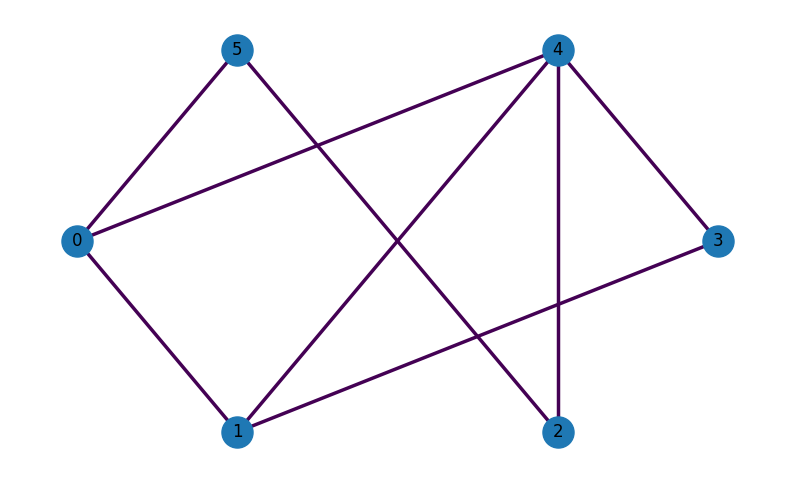

In [279]:
from openqaoa.utilities import plot_graph
plot_graph(G)